Lane Reconstruction

Import Lane Lines

In [ ]:
import pandas as pd
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt

# Define the relative path to the  file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
data_path = project_root / 'data' / 'auxiliary_data' / 'lane_lines' / 'lane_lines_2.csv'
# Load the CSV file into a DataFrame
lane_lines_df = pd.read_csv(data_path)

# Display the first few rows of the DataFrame
lane_lines_df.head()

,rho,theta
0,-485.75486,-1.563104
1,937.00000,1.588250
2,1069.00000,0.733038
3,-1173.00000,2.844886


Extract Lines \
Order:\
Top - Bottom - Left - Right

In [20]:
top_line_h = lane_lines_df.iloc[0]
bottom_line_h = lane_lines_df.iloc[1]
left_line_h = lane_lines_df.iloc[2]
right_line_h = lane_lines_df.iloc[3]

Convert Lines in Homogeneous Coordinates

In [21]:
import numpy as np

def to_homogeneous(rho, theta):
    return np.array([np.cos(theta), np.sin(theta), -rho])/(-rho)

top_line = to_homogeneous(top_line_h['rho'], top_line_h['theta'])
bottom_line = to_homogeneous(bottom_line_h['rho'], bottom_line_h['theta'])
left_line = to_homogeneous(left_line_h['rho'], left_line_h['theta'])
right_line = to_homogeneous(right_line_h['rho'], right_line_h['theta'])

print("Top Line Homogeneous:", top_line)
print("Bottom Line Homogeneous:", bottom_line)
print("Left Line Homogeneous:", left_line)
print("Right Line Homogeneous:", right_line)

Top Line Homogeneous: [ 1.58353127e-05 -2.05859066e-03  1.00000000e+00]
Bottom Line Homogeneous: [ 1.86258134e-05 -1.06707331e-03  1.00000000e+00]
Left Line Homogeneous: [-6.95177564e-04 -6.25940708e-04  1.00000000e+00]
Right Line Homogeneous: [-8.15264027e-04  2.49251388e-04  1.00000000e+00]


Compute the 4 corners

In [22]:
A = np.cross(bottom_line, left_line)
B = np.cross(bottom_line, right_line)
C = np.cross(top_line, right_line)
D = np.cross(top_line, left_line)

A = A/A[2]
B = B/B[2]
C = C/C[2]
D = D/D[2]

print("A:", A)
print("B:", B)
print("C:", C)
print("D:", D)

A: [585.47264127 947.36218272   1.        ]
B: [1.52122807e+03 9.63695836e+02 1.00000000e+00]
C: [1.37835273e+03 4.96371944e+02 1.00000000e+00]
D: [994.2067538  493.41697503   1.        ]


In [ ]:
# Definisci i quattro punti
points = np.array([A, B, C, D])

# Crea un DataFrame con i punti
points_df = pd.DataFrame(points, columns=['x', 'y', 'z'])

# Definisci il percorso del file
data_path = project_root / 'data' / 'auxiliary_data' / 'lane_points_2.csv'

# Salva il DataFrame in un file CSV
points_df.to_csv(data_path, index=False)


Compute Vanishing Points

In [26]:
vanishing_point_horizontal = np.cross(top_line, bottom_line)
vanishing_point_horizontal = vanishing_point_horizontal/vanishing_point_horizontal[2]
vanishing_point_vertical = np.cross(left_line, right_line)
vanishing_point_vertical = vanishing_point_vertical/vanishing_point_vertical[2]

print("Horizontal Vanishing Point:", vanishing_point_horizontal)
print("Vertical Vanishing Point", vanishing_point_vertical)

Horizontal Vanishing Point: [-4.62343150e+04  1.30120654e+02  1.00000000e+00]
Vertical Vanishing Point [1.28030505e+03 1.75672638e+02 1.00000000e+00]


Compute Vanishing Line

In [28]:
vanishing_line = np.cross(vanishing_point_vertical, vanishing_point_horizontal)
vanishing_line = vanishing_line/vanishing_line[2]
print(vanishing_line)

[ 5.49567412e-06 -5.73245869e-03  1.00000000e+00]


Import correct frame

Opened: True, FPS: 59.94005994005994, Total Frames: 276.0


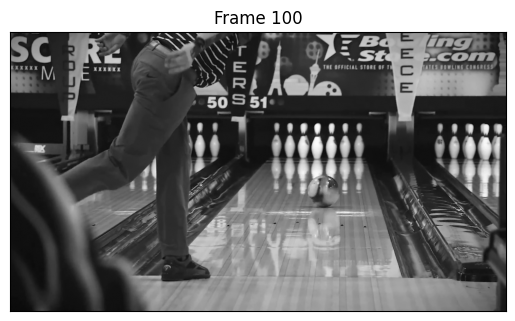

In [29]:
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / "recording_2" / "Recording_2_normal_speed.mp4"
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")
# Set frame position
cap.set(cv2.CAP_PROP_POS_FRAMES, 100)
ret, colored_image = cap.read()
if not ret:
    print("Failed to read the frame")
    cap.release()
    exit()

# grayscale
image = cv2.cvtColor(colored_image, cv2.COLOR_BGR2GRAY)

# Show the image
plt.imshow(image, cmap='gray')
plt.title('Frame 100')
plt.xticks([]), plt.yticks([])
plt.show()

Compute affine transformation

In [30]:
H_a = np.array([[1, 0, 0], [0, 1, 0], vanishing_line])
print(H_a)

[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 5.49567412e-06 -5.73245869e-03  1.00000000e+00]]


Apply affine transformation

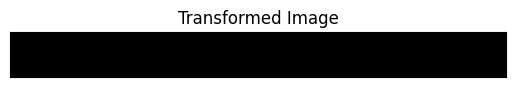

In [36]:
# Calculate the size of the output image to ensure the entire transformed image is visible
height, width = image.shape
# corners = np.array([[0, 0, 1], [width, 0, 1], [width, height, 1], [0, height, 1]])

# Define corners (convert to float32)
corners = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype=np.float32)

# Reshape to (N,1,2) before perspective transformation
corners = corners.reshape(-1, 1, 2)

transformed_corners = cv2.perspectiveTransform(corners, H_a)

# Flatten result
transformed_corners = transformed_corners.reshape(-1, 2)

# Find the bounding box of the transformed corners
min_x = min(transformed_corners[:, 0])
max_x = max(transformed_corners[:, 0])
min_y = min(transformed_corners[:, 1])
max_y = max(transformed_corners[:, 1])

# Calculate the size of the new image
new_width = int(max_x - min_x)
new_height = int(max_y - min_y)

# Adjust the homography to account for the translation
translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
adjusted_H_a = translation_matrix @ H_a

# Apply the adjusted homography to the image
transformed_image = cv2.warpPerspective(image, adjusted_H_a, (new_width, new_height))

# Show the transformed image
plt.imshow(transformed_image, cmap='gray')
plt.title('Transformed Image')
plt.xticks([]), plt.yticks([])
plt.show()